## Data Shift
- 資料集分布發生改變，真實世界非常常見，通常會透過偵測去即時通知，減少實務上的成本消耗。
- 類型
    1. Convariate shift
    2. Prior probability shift
    3.  Concept drift

### 1. Convariate shift
公式定義
$$P(Y|X)_{train} = P(Y|X)_{test}, but P(X)_{train} \neq P(X)_{test}$$
步驟
1. 將資料集各自加上新的變數['is_train'] = 1 / 0
2. 將資料集訓練與測試集合併 並且shuffle
3. 將資料集切分成train/test
4. for loop 每一個特徵當作輸入建立一個分類模型去預測 is_train
    - 4-1. 訓練
    - 4-2. 計算AUC
    - 4-3. 透過AUC去判斷一個threshold, 如0.8, 如果超過就是有data shift
 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from pprint import pprint

In [2]:
# 使用隨機森林，因為簡單不用標準化，方便


data = load_boston(return_X_y=False)
# print(x.shape, y.shape)
print(data['data'].shape)
print(data['target'].shape)
print(data.keys())

df = pd.DataFrame(data=np.concatenate((data['data'], data['target'].reshape(-1,  1)), axis=1), columns=data['feature_names'].tolist()+['target'])


# 1. 加上新變數 is_train, 這邊的例子我先打散一次，再把前面80%當做train, 後20%當做test
num = int(len(df) * 0.8)

df = df.sample(frac=1)
label = [1 for _ in range(num)] + [0 for _ in range(len(df)-num)]
df['is_train'] = label
print(df)


# 2. shuffle
df = df.sample(frac=1)
print(df)


# 3. 切分成train/test
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

(506, 13)
(506,)
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
         CRIM   ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
443   9.96654  0.0  18.10   0.0  0.740  6.485  100.0  1.9784  24.0  666.0   
397   7.67202  0.0  18.10   0.0  0.693  5.747   98.9  1.6334  24.0  666.0   
17    0.78420  0.0   8.14   0.0  0.538  5.990   81.7  4.2579   4.0  307.0   
167   1.80028  0.0  19.58   0.0  0.605  5.877   79.2  2.4259   5.0  403.0   
32    1.38799  0.0   8.14   0.0  0.538  5.950   82.0  3.9900   4.0  307.0   
..        ...  ...    ...   ...    ...    ...    ...     ...   ...    ...   
162   1.83377  0.0  19.58   1.0  0.605  7.802   98.2  2.0407   5.0  403.0   
411  14.05070  0.0  18.10   0.0  0.597  6.657  100.0  1.5275  24.0  666.0   
86    0.05188  0.0   4.49   0.0  0.449  6.015   45.1  4.4272   3.0  247.0   
501   0.06263  0.0  11.93   0.0  0.573  6.593   69.1  2.4786   1.0  273.0   
210   0.17446  0.0  10.59   1.0  0.489  5.960   92.1  3.8771   4.0  

In [3]:
# 4. 透過每一個特徵去預測

d = {}

for i in range(len(X_train.columns)):
    x = X_train.iloc[:, i:i+1] # 這樣寫才會是2-d
    rf = RandomForestClassifier()
    rf.fit(x, y_train)
    y_pred = rf.predict(x)     # 類別
    y_test_pred = rf.predict(X_test.iloc[:, i:i+1])
        
    acc_train = accuracy_score(y_train, y_pred)
    auc_train = roc_auc_score(y_train, rf.predict_proba(x)[:, 1])
    
    acc_test = accuracy_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, rf.predict_proba(X_test.iloc[:, i:i+1])[:, 1])
    d[X_train.columns[i]] = {
        #'acc_train': acc_train,
        'acc_test': acc_test,
        #'auc_train': auc_train,
        'auc_test': auc_test
    }

pprint(d)

{'AGE': {'acc_test': 0.7058823529411765, 'auc_test': 0.5028409090909091},
 'B': {'acc_test': 0.696078431372549, 'auc_test': 0.5460227272727273},
 'CHAS': {'acc_test': 0.7843137254901961, 'auc_test': 0.5142045454545455},
 'CRIM': {'acc_test': 0.7058823529411765, 'auc_test': 0.4798295454545454},
 'DIS': {'acc_test': 0.7058823529411765, 'auc_test': 0.4732954545454546},
 'INDUS': {'acc_test': 0.7549019607843137, 'auc_test': 0.41647727272727275},
 'LSTAT': {'acc_test': 0.6764705882352942, 'auc_test': 0.5786931818181819},
 'NOX': {'acc_test': 0.7352941176470589, 'auc_test': 0.4315340909090909},
 'PTRATIO': {'acc_test': 0.7647058823529411, 'auc_test': 0.43153409090909084},
 'RAD': {'acc_test': 0.7843137254901961, 'auc_test': 0.4326704545454545},
 'RM': {'acc_test': 0.6274509803921569, 'auc_test': 0.5161931818181819},
 'TAX': {'acc_test': 0.7254901960784313, 'auc_test': 0.4039772727272727},
 'ZN': {'acc_test': 0.7941176470588235, 'auc_test': 0.5511363636363636},
 'target': {'acc_test': 0.75490

In [4]:
def check_data_shift(x_train, y_train, x_test, y_test, s_type='convariate shift') -> dict:
    """
        將上述過程包裝成可重複利用的function
        *先想輸入輸出，也許先把其他種寫好再說
    """
    if s_type == 'convariate shift':
        x_train['is_train'] = 1
        x_test['is_train'] = 0
        X = x_train.append(x_test, ignore_index=True)
        y = y_train.append(y_test, ingore_index=True)
        

### 2. Prior probability shift
公式定義
$$P(X|Y)_{train} = P(X|Y)_{test}, but P(Y)_{train} \neq P(Y)_{test}$$
步驟
1. 計算訓練、測試集的各自的類別機率
2. 透過ANOVA、T-test 去檢驗是否有顯著差異
    - Yes -> 拒絕$H_{0}$, 代表有 Prior probability shift
    - No  -> 不拒絕$H_{0}$, 代表 沒有 Prior probality shift

In [5]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# print(X)
# print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6)
print(y_train.shape, y_test.shape)

(426,) (143,)


In [6]:
# 1. 計算P(Y)

py_train = (y_train == 1).sum() / len(y_train)
py_test = (y_test == 1).sum() / len(y_test)

print(py_train, py_test)

0.6572769953051644 0.5384615384615384


In [7]:
from scipy.stats import ttest_ind

# 2. t-test

result = ttest_ind(y_train, y_test)
print(result.pvalue)
print(result.statistic)

0.010946905364189472
2.5527999897365663


> 透過將random_state設定，找到P(Y)是有差距的樣本，可以去發現其$p_{value}$ < 0.05, 是拒絕$H_{0}$的，有產生data shift

In [8]:
# 此時透過模型去預測看看

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_train)
acc_train = accuracy_score(y_train, y_pred)

y_pred_test= rf.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(acc_train, acc_test)

1.0 0.951048951048951


### 3. Concept drift
公式定義
$$P(Y|X)_{train} \neq P(Y|X)_{test}$$
Concept drift 可能發生於季節因素，Concept drift 尤其容易發生於時間相關的資料。舉例來說，可能有一個ML模型想要去fit 給定一段時間的銷售資料，銷售資料可能有daily、weekly、monthly、yearly等pattern，如果模型沒有把這些考慮進去，可能不會fit得很好。要解決這個問題，我們可以重新處理資料，著手於資料的定態(stationary)部分，或者用time-series、cross-validation去解決。
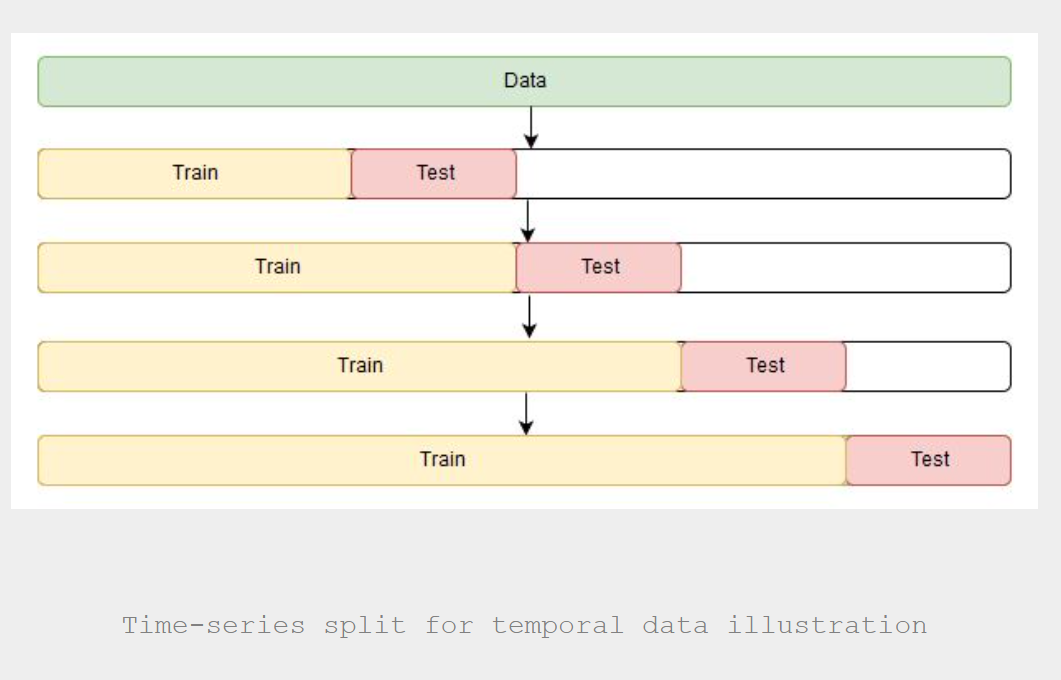
步驟
1. 將資料集透過時間切分。
2. 透過模型去預測得到cross-validation score，判斷是否有顯著差異。

In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(C=1, random_state=222, solver='liblinear')   # solver: optimization 選擇
cv_scores = cross_val_score(estimator=logit, X=x_train, y=y_train, cv=time_split, scoring='roc_auc', n_jobs=1)
cv_scores

array([0.98467433, 0.98611111, 1.        , 0.875     , 0.97681159,
       1.        , 0.9942029 , 0.95384615, 0.99679487, 0.99702381])

## 總結
- data shift較常發生於tabular data中，像是圖片相關的比較穩定，因為拍照出來的資料如果是動物，那麼動物不太容易短時間內產生劇烈變化，而tabular data常常是由人生成的，人的行為常常因為某些事情發生劇烈影響，如Covid-19對各產業的衝擊，那段時間收集到的資料可能也會產生劇烈變化，模型也會產生degrade。
- 那麼要怎麼去決定re-train的時間呢 ?這是一個不容易回答的問題，根據領域、資料類型、模型、訓練成本等等，都會有daily to yearly的不同。但最基本可以使用monitor監測model是否degrade，只要degrade就幾乎需要re-train，而偵測data shift就可以很好地幫助去檢測。